In [21]:
import numpy as np
import torch as th
import torchvision
import blobfile as bf
import PIL
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


In [33]:
def _list_image_files_recursively(data_dir):
    results = []
    for entry in sorted(bf.listdir(data_dir)):
        full_path = bf.join(data_dir, entry)
        ext = entry.split(".")[-1]
        if "." in entry and ext.lower() in ["jpg", "jpeg", "png", "gif"]:
            results.append(full_path)
        elif bf.isdir(full_path):
            results.extend(_list_image_files_recursively(full_path))
    return results

def get_image(path, resize_mode=PIL.Image.ANTIALIAS):
    with bf.BlobFile(path, "rb") as f:
        pil_image = PIL.Image.open(f)
        pil_image.load()
    pil_image = pil_image.convert("RGB")
    image = pil_image.resize((64, 64), resize_mode)
    image = np.array(image)

    return image

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(30, 30))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def face_segment(raw_pil_image, face_segment_image, segment_part):

        face_segment_anno = np.array(face_segment_image)
        bg = (face_segment_anno == 0)
        skin = (face_segment_anno == 1)
        l_brow = (face_segment_anno == 2)
        r_brow = (face_segment_anno == 3)
        l_eye = (face_segment_anno == 4)
        r_eye = (face_segment_anno == 5)
        eye_g = (face_segment_anno == 6)
        l_ear = (face_segment_anno == 7)
        r_ear = (face_segment_anno == 8)
        ear_r = (face_segment_anno == 9)
        nose = (face_segment_anno == 10)
        mouth = (face_segment_anno == 11)
        u_lip = (face_segment_anno == 12)
        l_lip = (face_segment_anno == 13)
        neck = (face_segment_anno == 14)
        neck_l = (face_segment_anno == 15)
        cloth = (face_segment_anno == 16)
        hair = (face_segment_anno == 17)
        hat = (face_segment_anno == 18)
        face = np.logical_or.reduce((skin, l_brow, r_brow, l_eye, r_eye, eye_g, l_ear, r_ear, ear_r, nose, mouth, u_lip, l_lip))

        if segment_part == 'faceseg_face':
            return face * np.array(raw_pil_image)
        elif segment_part == 'faceseg_face&hair':
            return ~bg * np.array(raw_pil_image)
        elif segment_part == 'faceseg_bg':
            return bg * np.array(raw_pil_image)
        elif segment_part == 'faceseg_bg&noface':
            return (bg | hair | hat | neck | neck_l | cloth) * np.array(raw_pil_image)
        elif segment_part == 'faceseg_hair':
            return hair * np.array(raw_pil_image)
        elif segment_part == 'faceseg_faceskin':
            return skin * np.array(raw_pil_image)
        elif segment_part == 'faceseg_faceskin&nose':
            return (skin | nose) * np.array(raw_pil_image)
        elif segment_part == 'faceseg_face_noglasses':
            return (~eye_g & face) * np.array(raw_pil_image)
        elif segment_part == 'faceseg_face_noglasses_noeyes':
            return (~(l_eye | r_eye) & ~eye_g & face) * np.array(raw_pil_image)
        elif segment_part == None:
            return np.array(raw_pil_image)

def blur(img, k, sigma_list):
    if img.shape[0] != 3:
        img = np.transpose(img, (2, 0, 1))

    blur_imgs = [th.tensor(img)]
    for sigma in sigma_list:
        tmp = img.copy()
        blur_kernel = torchvision.transforms.GaussianBlur(kernel_size=k, sigma=sigma)
        blur_img = blur_kernel(th.tensor(tmp))

        blur_imgs.append(blur_img)

    grid = torchvision.utils.make_grid(th.stack(blur_imgs, dim=0))
    batch = th.stack(blur_imgs, dim=0)
    return batch, grid


# def save_segment(img_name, raw_img, segment_part, segment_img, sigma_list, k):
#     # Raw color
#     seg_img = face_segment(raw_img, segment_img, segment_part=segment_part)
#     batch_seg_blur, face_img_grid = blur(seg_img, k=k, sigma_list=sigma_list)
#     import os
#     os.makedirs(f"./gen/{img_name}/{segment_part}/", exist_ok=True)
#     sigma_list = [0] + list(sigma_list)
#     for idx, img in enumerate(batch_seg_blur):
#         torchvision.utils.save_image(img/255, fp=f'./gen/{img_name}/{segment_part}/{str(idx).zfill(3)}_{segment_part}_{sigma_list[idx]}_blur_img.png')


def save_segment(img_name, raw_img, segment_part, segment_img, sigma_list, k):
    # Raw color
    seg_img = face_segment(raw_img, segment_img, segment_part=segment_part)
    batch_seg_blur, _ = blur(seg_img, k=k, sigma_list=sigma_list)
    # Varying color
    color = 'Y_Cb_Cr'
    pil_img = PIL.Image.fromarray(seg_img)
    seg_clr_img = np.array(pil_img.convert('YCbCr'))
    # print(np.max(seg_clr_img, axis=(0, 1)))
    # print(np.min(seg_clr_img, axis=(0, 1)))
    batch_seg_clr_blur, _ = blur(seg_clr_img, k=k, sigma_list=sigma_list)
    import os
    os.makedirs(f"./gen/{img_name}/{segment_part}/raw/", exist_ok=True)
    os.makedirs(f"./gen/{img_name}/{segment_part}/YCbCr/", exist_ok=True)
    sigma_list = [0] + list(sigma_list)
    for idx, img in enumerate(batch_seg_blur):
        torchvision.utils.save_image(img/255, fp=f'./gen/{img_name}/{segment_part}/raw/{str(idx).zfill(3)}_{segment_part}_{sigma_list[idx]}_blur_img.png')

    for idx, img in enumerate(batch_seg_clr_blur):
        torchvision.utils.save_image(img[[0], ...]/255, fp=f'./gen/{img_name}/{segment_part}/YCbCr/{str(idx).zfill(3)}_{segment_part}_{sigma_list[idx]}_blur_Y-chn_img.png')


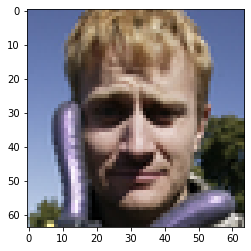

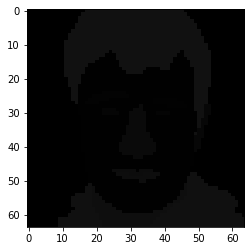

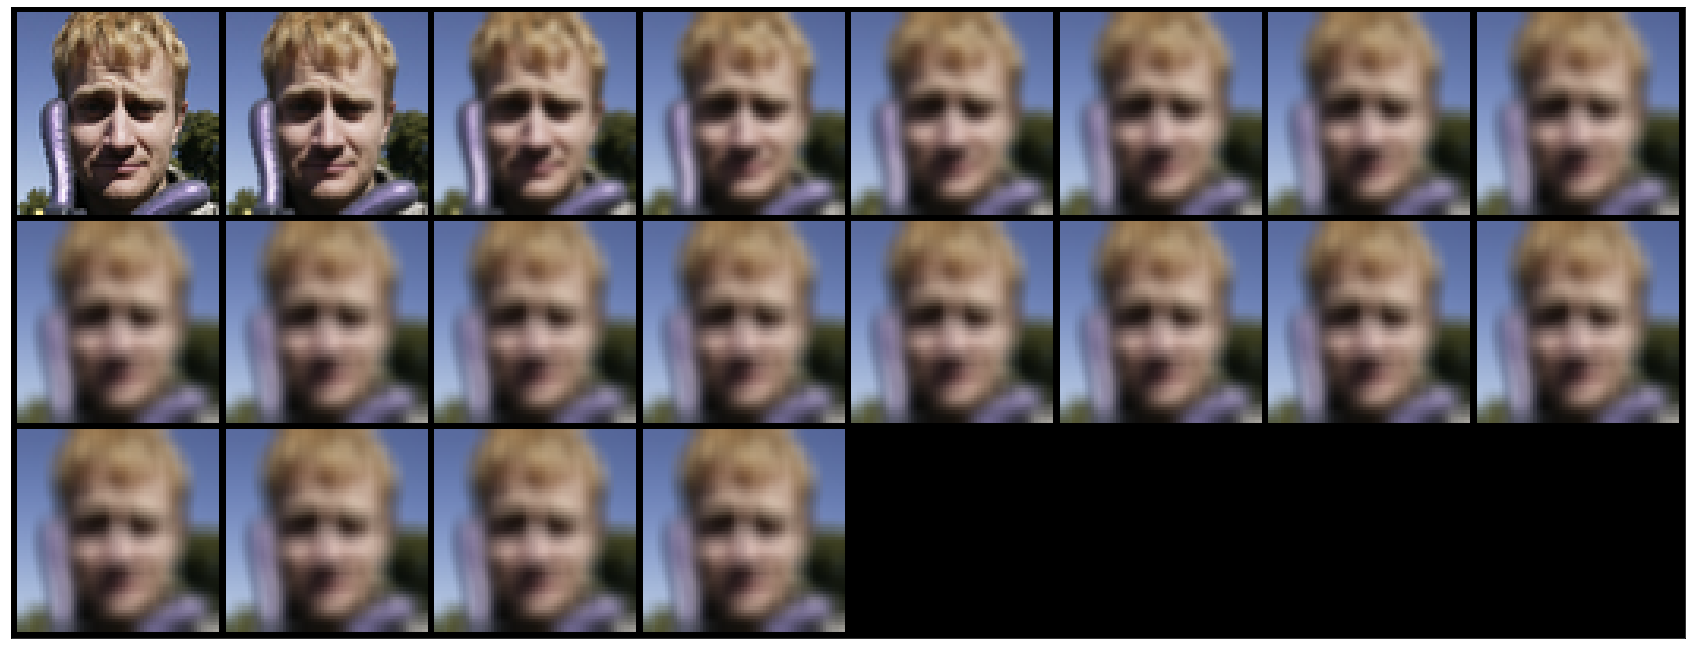

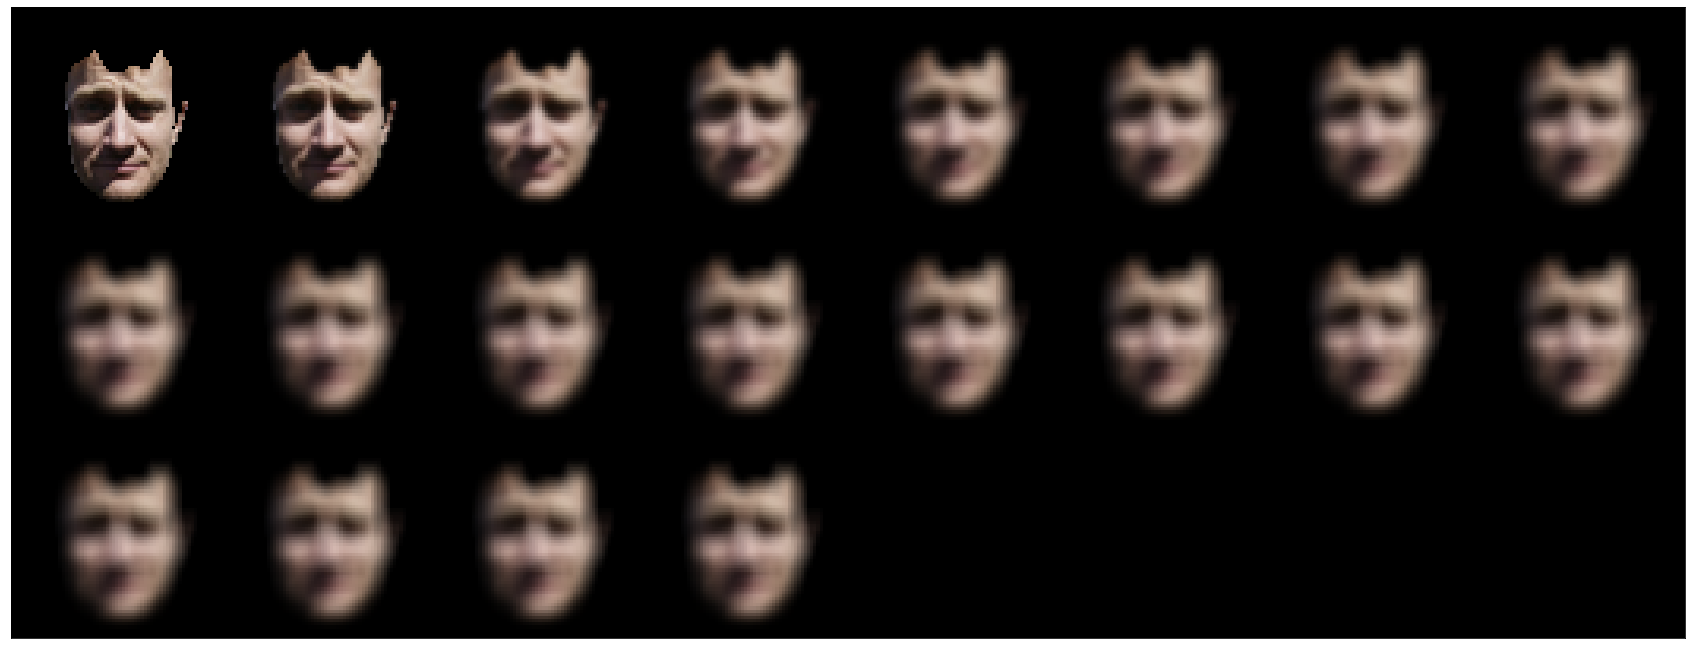

In [23]:
from cv2 import resize

set_ = 'valid'
data_dir = f'/data/mint/ffhq_256_with_anno/ffhq_256/{set_}'
images = _list_image_files_recursively(data_dir)
segment_dir = f'/data/mint/ffhq_256_with_anno/face_segment/{set_}/'
segment_images = _list_image_files_recursively(segment_dir)

image_dict = {}
for raw_path, segment_path in zip(images, segment_images):
    assert raw_path.split('/')[-1] == segment_path.split('/')[-1].split('_')[-1].replace('.png', '.jpg')
    img_name = raw_path.split('/')[-1]
    image_dict[img_name] = {}
    image_dict[img_name]['raw'] = raw_path
    image_dict[img_name]['segment'] = segment_path

raw_img = get_image(image_dict['60065.jpg']['raw'], resize_mode=PIL.Image.ANTIALIAS)
raw_img_tmp = raw_img.copy()
segment_img = get_image(image_dict['60065.jpg']['segment'], resize_mode=PIL.Image.NONE)
plt.imshow(raw_img)
plt.show()

plt.imshow(segment_img)
plt.show()
k = int(raw_img.shape[0] * 0.1)
k = k if k%2 != 0 else k+1
sigma_list = np.arange(0.5, 10, 0.5)

batch_raw_blur, raw_img_grid = blur(raw_img, k=k, sigma_list=sigma_list)
show(raw_img_grid)


segment_part = 'faceseg_face'
face_img = face_segment(raw_img_tmp, segment_img, segment_part=segment_part)
batch_face_blur, face_img_grid = blur(face_img, k=k, sigma_list=sigma_list)
show(face_img_grid)

import os
img_name = '60065.jpg'
os.makedirs(f"./{img_name}/{segment_part}/", exist_ok=True)
sigma_list = [0] + list(sigma_list)
for idx, img in enumerate(batch_face_blur):
    torchvision.utils.save_image(img/255, fp=f'./{img_name}/{segment_part}/{str(idx).zfill(3)}_{segment_part}_{sigma_list[idx]}_blur_img.png')

# Normalize image from [0, 1] => [-1, 1]
# norm = torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
# print(th.max(norm(th.tensor(img/255))))
# print(th.min(norm(th.tensor(img/255))))


In [34]:
from pytorch_lightning import seed_everything


set_ = 'valid'
data_dir = f'/data/mint/ffhq_256_with_anno/ffhq_256/{set_}'
images = _list_image_files_recursively(data_dir)
segment_dir = f'/data/mint/ffhq_256_with_anno/face_segment/{set_}/'
segment_images = _list_image_files_recursively(segment_dir)

image_dict = {}
for raw_path, segment_path in zip(images, segment_images):
    assert raw_path.split('/')[-1] == segment_path.split('/')[-1].split('_')[-1].replace('.png', '.jpg')
    img_name = raw_path.split('/')[-1]
    image_dict[img_name] = {}
    image_dict[img_name]['raw'] = raw_path
    image_dict[img_name]['segment'] = segment_path

def generate_segment_blur(img_name, segment_part):
    raw_img = get_image(image_dict[img_name]['raw'], resize_mode=PIL.Image.ANTIALIAS)
    segment_img = get_image(image_dict[img_name]['segment'], resize_mode=PIL.Image.NONE)

    k = int(raw_img.shape[0] * 0.1)
    k = k if k%2 != 0 else k+1
    sigma_list = np.arange(0.5, 15, 0.5)
    save_segment(img_name=img_name, raw_img=raw_img, segment_part=segment_part, segment_img=segment_img, sigma_list=sigma_list, k=k)


seed_everything(47)
import random
rand = random.sample(list(image_dict.keys()), 10)
img_list = ['60065.jpg', '60008.jpg', '60012.jpg', '60059.jpg', '60619.jpg', '62011.jpg'] + list(rand)
segment_part_list = ['faceseg_face', 'faceseg_bg&noface', 'faceseg_faceskin&nose', 'faceseg_face_noglasses', 'faceseg_face_noglasses_noeyes', 'faceseg_faceskin', 'faceseg_face&hair', 'faceseg_hair', 'faceseg_bg', None]
for img in img_list:
    for s in segment_part_list:
        generate_segment_blur(img_name=img, segment_part=s)



Global seed set to 47


[223 134 155]
[  0 106 126]
[252 161 151]
[  0  79 110]
[223 134 155]
[  0 106 126]
[223 134 155]
[  0 106 126]
[223 134 155]
[  0 106 126]
[218 134 155]
[  0 106 126]
[252 152 155]
[  0  98 119]
[217 145 151]
[  0  98 119]
[247 161 143]
[  0  79 110]
[252 161 155]
[  0  79 110]
[240 132 163]
[  0 102 127]
[210 166 167]
[  0  99 111]
[240 132 160]
[  0 103 127]
[240 132 163]
[  0 102 127]
[240 132 163]
[  0 102 127]
[236 132 159]
[  0 103 127]
[240 166 163]
[  0 102 111]
[134 132 151]
[  0 110 126]
[ 85 135 167]
[  0  99 121]
[240 166 167]
[  0  99 111]
[251 153 155]
[  0 114 102]
[213 182 131]
[  0 123  98]
[251 151 140]
[  0 121 117]
[251 153 155]
[  0 114 117]
[251 153 155]
[  0 114 117]
[251 151 138]
[  0 121 117]
[251 166 155]
[  0 114 102]
[162 166 130]
[  0 126 108]
[138 182 128]
[  0 128  98]
[251 182 155]
[  0 114  98]
[254 128 208]
[  0  75 126]
[255 146 168]
[  0  92 115]
[254 128 180]
[  0  81 126]
[254 128 208]
[  0  75 126]
[254 128 208]
[  0  75 126]
[252 128 180]
[  0  

In [ ]:
def generate_color_blur(img_name, color='Y_Cb_Cr'):
    if color == 'Y_Cb_Cr':
        dst_color = 'YCbCr'
    elif color == 'R_G_B':
        dst_color = 'RGB'
    else: raise NotImplementedError
    raw_img = get_image(image_dict[img_name]['raw'], resize_mode=PIL.Image.ANTIALIAS)
    pil_img = PIL.Image.fromarray(raw_img)
    pil_img = pil_img.convert(dst_color)
    raw_img = np.array(pil_img)
    k = int(raw_img.shape[0] * 0.1)
    k = k if k%2 != 0 else k+1
    sigma_list = np.arange(0.5, 15, 0.5)

    batch_color_blur, _ = blur(raw_img, k=k, sigma_list=sigma_list)
    sigma_list = [0] + list(sigma_list)
    for idx, img in enumerate(batch_color_blur):
        for j, c in enumerate(color.split('_')):
            tmp = img.clone()
            # if color == 'R_G_B':
            #     if j == 0:
            #         tmp = th.cat((tmp[[0], ...], tmp[[1], ...]*0, tmp[[2], ...]*0))
            #     elif j == 1:
            #         tmp = th.cat((tmp[[0], ...]*0, tmp[[1], ...], tmp[[2], ...]*0))
            #     elif j == 2:
            #         tmp = th.cat((tmp[[0], ...]*0, tmp[[1], ...]*0, tmp[[2], ...]))
            # elif color == 'Y_Cb_Cr':
            #     if j == 0:
            #         tmp = th.cat((tmp[[0], ...], (tmp[[1], ...]*0) + 128, (tmp[[2], ...]*0)+128))
            #     elif j == 1:
            #         tmp = th.cat(((tmp[[0], ...]*0) + 128, tmp[[1], ...], (tmp[[2], ...]*0) + 128))
            #     elif j == 2:
            #         tmp = th.cat(((tmp[[0], ...]*0)+128, (tmp[[1], ...]*0)+128, tmp[[2], ...]))
            os.makedirs(f"./gen/{img_name}/{color}/{c}/", exist_ok=True)
            tmp = tmp/255.
            # torchvision.utils.save_image(th.cat([img[[j], ...]/255]*3, dim=0), fp=f'./gen/{img_name}/{color}/{c}/{str(idx).zfill(3)}_{c}_{sigma_list[idx]}_blur_img.png')
            torchvision.utils.save_image(tmp[[j], ...], fp=f'./gen/{img_name}/{color}/{c}/{str(idx).zfill(3)}_{c}_{sigma_list[idx]}_blur_img.png')

img_list = ['60065.jpg', '60008.jpg', '60012.jpg', '60059.jpg', '60619.jpg', '62011.jpg'] + list(rand)
for img in img_list:
    generate_color_blur(img_name=img, color='Y_Cb_Cr')
    generate_color_blur(img_name=img, color='R_G_B')
